In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [ ]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':128, 'width':128, 'channels':3}

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [3]:
import os

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [01:35<00:00, 42.1MB/s]


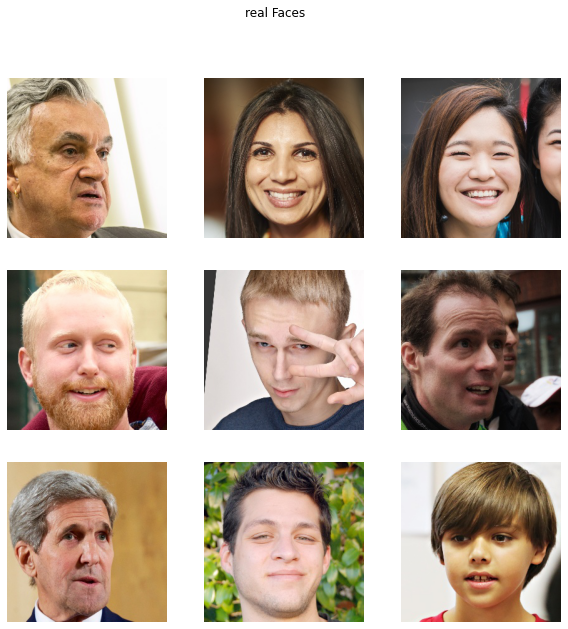

In [ ]:
path = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

In [ ]:
bs = 64
row, col = 128, 128
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [4]:
model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (128, 128, 3)),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.5),

    #  tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(2, activation='softmax')
     ]
)


In [5]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import pydotplus
import pydot


In [6]:
tf.keras.utils.pydot = pydot

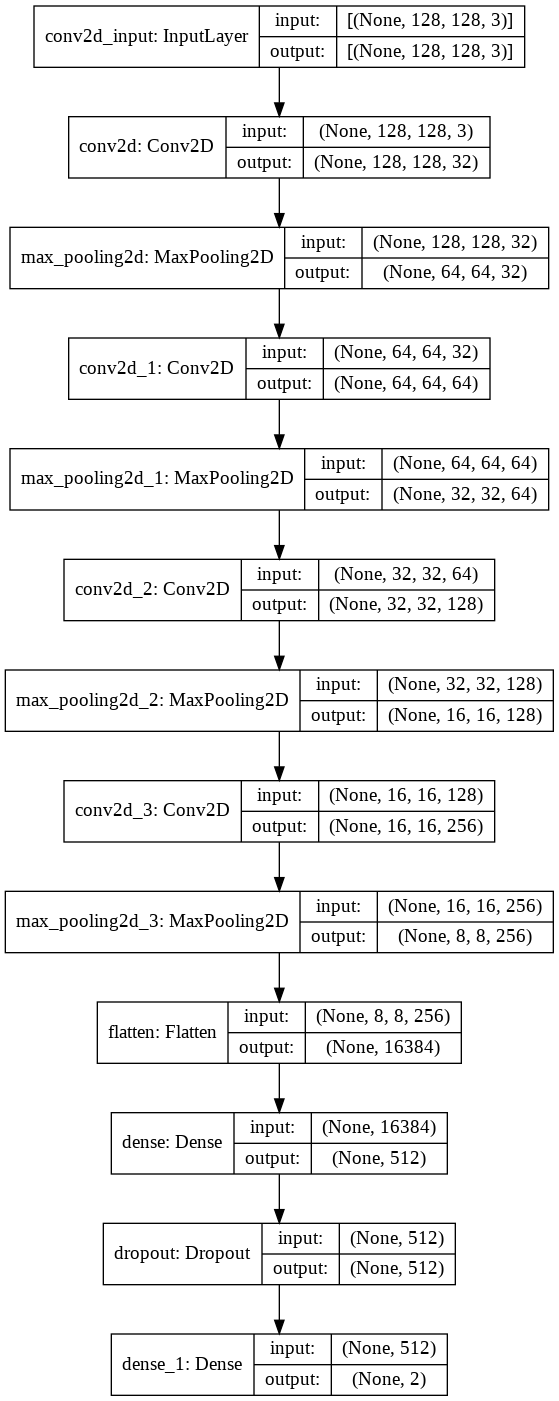

In [7]:
plot_model(model, to_file='model.png', show_shapes=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 10
batch_size = 100
init_lr = 1e-5
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/MiniNet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=10, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')

early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.001,
                              patience =5,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [ ]:
%%time
history = model.fit(training_set, validation_data = validation_set, epochs = epochs, validation_steps = 100, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.0463 - accuracy: 0.9848 - val_loss: 0.1984 - val_accuracy: 0.9528
Epoch 2/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.0498 - accuracy: 0.9839 - val_loss: 0.1513 - val_accuracy: 0.9658
Epoch 3/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.0471 - accuracy: 0.9846 - val_loss: 0.2345 - val_accuracy: 0.9555
Epoch 4/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.0467 - accuracy: 0.9845 - val_loss: 0.2071 - val_accuracy: 0.9583
Epoch 5/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.0468 - accuracy: 0.9834 - val_loss: 0.1974 - val_accuracy: 0.9531
Epoch 6/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.1540 - val_accuracy: 0.9659
Epoch 7/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.0476 - accuracy: 0.9842 - val_

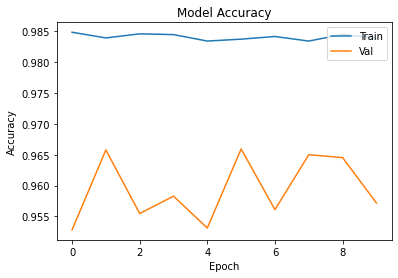

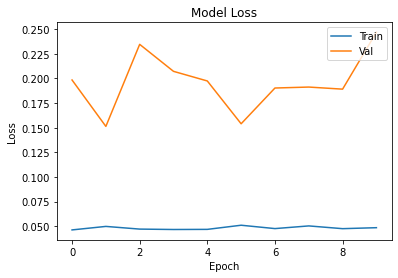

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_set)

313/313 [==============================] - 41s 132ms/step - loss: 0.2569 - accuracy: 0.9518


**Model Architecture**

In [10]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import pydotplus
import pydot

In [11]:
tf.keras.utils.pydot = pydot

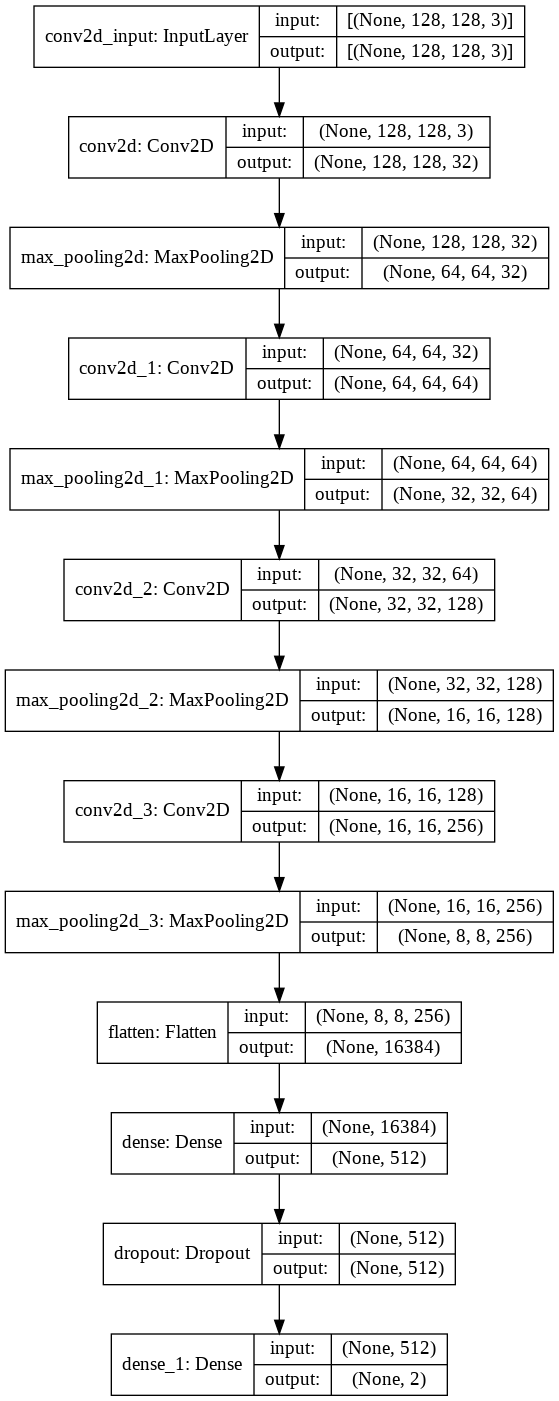

In [12]:
plot_model(model, to_file='model.png', show_shapes=True)